# Телеком: отток клиентов

## Условие

В рамках борьбы за уменьшение оттока клиентов оператор связи планирует предлагать скидки и специальные предложения клиентам, которые хотят уйти. Для этого ему необходимо научиться прогнозировать отток клиентов, а именно: __классифицировать клиентов на тех, кто уйдет, и тех кто останется__. Оператор собрал информацию об тарифах и договорах клиентов, об услугах, которые подключили клиенты и некоторые их персональные данные.

### Описание услуг

Оператор предоставляет два основных типа услуг: 

1. Стационарная телефонная связь. Дополниетлная опция: многокалнальная телефония - подключение аппарата к нескольким линиям.
2. Интернет. Подключение может быть через телефонную линию (DSL) или через оптоволоконный кабель (Fiber optic). Дополнительные опции для интернета:
    - антивирус (*DeviceProtection*); 
    - блокировка небезопасных сайтов (*OnlineSecurity*);
    - Выделенная линия тех.поддержки (*TechSupport*);
    - Облачное хранилище для резервной копии данных (*OnlineBackup*);
    - Стриминговое телевидение (*StreamingTV*);
    - Онлайн-фильмотека (*StreamingMovies*).

Клиенты могут заключить договор на ежемесячную оплату или абонемент на 1 год или на 2 года. Доступны различные способы расчёта (электронный, по почте, автоматическое банковское списание и т.д.) и возможность получения электронного чека.

### Описание данных

Данные состоят из 4 файлов:

- информация о договоре;
- персональные данные клиента;
- информация об интернет-услугах;
- информация об услугах телефонии.

Во всех файлах столбец `customerID` содержит код клиента.

Информация о договорах актуальна на 1 февраля 2020.

## Задачи  

__Основная задача:__ подготовить модель, которая могла бы решать задачу классификации клиентов на потенциально уходящих и на отсающихся. Ключевая метрика по настоянию заказчика - roc-auc, но также просьба включить более наглядный для коллег из бизнеса показатель accuracy.  

__Дополнительная задача:__ коллеги из маркетинга просят проанализировать группы оставшихся и ушедших клиентов. Необходимо сравнить распределения величин ежемесячных платежей (MonthlyCharges)посчитать статистики (средние, минимальные и максимальные значения, квартили), постройте гистограммы распределения.

Также нужно сравнить поведение клиентов этих двух групп, то есть построить два любых графика, изображающих:
- долю пользователей телефонной связи;
- долю интернет-пользователей.

На основе краткого исследования надо будет предоставить __план__ работы.

В конце тетради необходимо написать __отчет__.

## План

1) Обработать данные.
    - В датафрейме contract необходимо заменить типы данных в столбцах BeginDate, TotalCharges; 
    - EndDate стоит обработать, возможно, имеет смысл создать столбец с булевыми значениями, а в самом столбце EndDate заменить значения No на первое февраля 2020;
    - В столбце TotalCharges есть пропуски, замаскированные под пробелы и потому не определяющиеся методом info(); возможно, пропуски есть и в других столбцах и датафреймах;
    - Для удобства стоит поменять регистр в названиях стобцов;
    - Следует объединить таблицы по признаку customerID.
2) Исследовать данные.
    - В распределении MonthlyChanges есть увеличенное количество клиентов с ежемесячными выплатами до 21, они занимают большой процент от выборки. Изучить подробнее на возможность ошибки/аномалии.
    - Изучить возможность зависимости между разными услугами, способами оплаты и типом договора и ежемесячным платежом и фактом ухода; Возможно, стоит отбросить часть маловлияющих на вероятность ухода признаков ради скорости обучения модели; 
3) Обучить модель.
    - Задача классификации, поэтому стоит привести целевой признак в соответствующую форму;
    - Порядок объектов не играет роли, поэтому, возможно, имеет смысл прибегнуть к кросс-валидации;
    - Возможно, имеет смысл рассчитать для пользователей длительность контракта и использовать его как признак (aka жизненный цикл потребителя)
    - Попробовать логистическую регрессию, случайный лес и градиентный бустинг; перебрать гиперпараметры;
4) Протестировать модель.
    - Выделить тестовую часть выборки и проверить на ней;
    - Ключевая метрика - roc-auc.
    

# Исследовательский анализ данных

Импортируем необходимые библиотеки и загрузим данные.

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import copy

from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

In [2]:
pip install catboost --no-cache-dir

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install lightgbm

Note: you may need to restart the kernel to use updated packages.


In [ ]:
from lightgbm import LGBMClassifier
from lightgbm import cv as lgbm_cv
from lightgbm import Dataset

from catboost import CatBoostClassifier
from catboost import cv
from catboost import Pool

In [4]:
df_contract = pd.read_csv('...')
df_internet = pd.read_csv('...')
df_personal = pd.read_csv('...')
df_phone = pd.read_csv('...')

In [5]:
state = 12345

## Предварительный осмотр данных

In [6]:
df_contract.head(10)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65
5,9305-CDSKC,2019-03-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,99.65,820.5
6,1452-KIOVK,2018-04-01,No,Month-to-month,Yes,Credit card (automatic),89.10,1949.4
7,6713-OKOMC,2019-04-01,No,Month-to-month,No,Mailed check,29.75,301.9
8,7892-POOKP,2017-07-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,104.80,3046.05
9,6388-TABGU,2014-12-01,No,One year,No,Bank transfer (automatic),56.15,3487.95


In [7]:
df_contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


В столбцах BeginDate, EndDate, TotalCharges стоит заменить типы данных.  
В столбце EndDate содержится информация о целевом признаке, хотя она приведена в неудобном формате для задачи классификации. Для удобства стоит создать столбец с булевыми значениями, принимающими True для контрактов, у которых стоит дата окончания, и False для тех, которые еще не истекли.  
В самом же EndDate можно No заменить на 2020.02.01, чтобы рассчитывать количество времени, которое действовал контракт на момент выгрузки. Это может быть полезным, во-первых, как признак для обучения модели, поскольку фактором ухода может оказаться просто продолжительность пользования услугами компании - у потребителя во многих сферах производства товаров и услуг есть свой жизненный цикл, к концу которого даже лояльный пользователь перестает потреблять продукты компании - так и для заполнения пропусков, если они обнаружатся.  

In [8]:
df_internet.head(10)

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No
5,9305-CDSKC,Fiber optic,No,No,Yes,No,Yes,Yes
6,1452-KIOVK,Fiber optic,No,Yes,No,No,Yes,No
7,6713-OKOMC,DSL,Yes,No,No,No,No,No
8,7892-POOKP,Fiber optic,No,No,Yes,Yes,Yes,Yes
9,6388-TABGU,DSL,Yes,Yes,No,No,No,No


In [9]:
df_internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


С датафреймом internet все на первый взгляд в порядке, очевидных пропусков нет, типы данных в целом подходят. Заменять типы на булевы в последних шести столбцах строгой необходимости нет, но для удобства, а так же для того, чтобы передать модели меньше категориальных признаков, можно будет заменить тип данных на булев.

In [10]:
df_personal.SeniorCitizen.unique()

array([0, 1], dtype=int64)

In [11]:
df_internet.InternetService.unique()

array(['DSL', 'Fiber optic'], dtype=object)

In [12]:
df_personal.head()

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


In [13]:
df_personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


С датафреймом personal все тоже на первый взгляд в порядке.

In [14]:
df_phone.head(10)

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes
5,7892-POOKP,Yes
6,6388-TABGU,No
7,9763-GRSKD,No
8,7469-LKBCI,No
9,8091-TTVAX,Yes


In [15]:
df_phone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


In [16]:
df_personal.SeniorCitizen.unique()

array([0, 1], dtype=int64)

### Вывод по итогу предварительного осмотра данных

В таблице df_contract стоит поменять типы данных у столбцов, подготовить целевой признак, заменить значения No в столбце EndDate. Также хорошо бы поменять регистр у названий столбцов во всех датафреймах.  

## Обработка данных

При попытке поменять тип данных в TotalCharges выдается ошибка в 488 строке.

In [17]:
df_contract.loc[488, 'TotalCharges']

' '

Выясняется, что в столбце есть пропуск, замаскированный под пробел и потому не обнаруженный с помощью метода info(). Таких пропусков в столбце 11.

In [18]:
df_contract[df_contract.TotalCharges == ' '].TotalCharges.count()

11

Несмотря на то, что этот столбец не нужен нам для выполнения просьбы маркетологов, для будущей работы будет полезно заменить его на нормальный пропуск.

In [19]:
df_contract.loc[df_contract.TotalCharges == ' ','TotalCharges'] = np.nan

In [20]:
df_contract['TotalCharges'] = pd.to_numeric(df_contract['TotalCharges'])

In [21]:
df_contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7032 non-null   float64
dtypes: float64(2), object(6)
memory usage: 440.3+ KB


Пропущенных значений не так много, посмотрим, что это за объекты.

In [22]:
df_contract.loc[df_contract.TotalCharges.isna()==True, :]

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
488,4472-LVYGI,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,NaN
753,3115-CZMZD,2020-02-01,No,Two year,No,Mailed check,20.25,NaN
936,5709-LVOEQ,2020-02-01,No,Two year,No,Mailed check,80.85,NaN
1082,4367-NUYAO,2020-02-01,No,Two year,No,Mailed check,25.75,NaN
1340,1371-DWPAZ,2020-02-01,No,Two year,No,Credit card (automatic),56.05,NaN
3331,7644-OMVMY,2020-02-01,No,Two year,No,Mailed check,19.85,NaN
3826,3213-VVOLG,2020-02-01,No,Two year,No,Mailed check,25.35,NaN
4380,2520-SGTTA,2020-02-01,No,Two year,No,Mailed check,20.00,NaN
5218,2923-ARZLG,2020-02-01,No,One year,Yes,Mailed check,19.70,NaN
6670,4075-WKNIU,2020-02-01,No,Two year,No,Mailed check,73.35,NaN


Оказывается, это пользователи, которые заключили договор в дату выгрузки. Им установлен размер ежемесячного платежа, однако, скорее всего, с них еще не успели снять деньги, или же платежная информация еще не была занесена в базу данных. Фактически, их накопленный платеж можно приравнять нулю.  
Однако, по большому счету, данные о них не несут нам никакой релевантной информации о вероятности ухода потребителя, поскольку уже на следующий день с даты выгрузки они могли и отказаться от услуг компании, пусть даже и заплатив за них.  
Правильнее все удалить эти данные, тем более их совсем немного.

In [23]:
df_contract = df_contract.dropna(subset = ['TotalCharges'])

Заодно заменим тип данных и в столбце BeginDate.

In [24]:
df_contract.BeginDate = pd.to_datetime(df_contract.BeginDate, format='%Y.%m.%d')

Для выполнения просьбы маркетологов, а так же для удобства и корректного обучения модели следует оформить целевой признак: создать столбец с булевым типом данных.

In [25]:
df_contract['has_quitted'] = df_contract.EndDate != 'No'

In [26]:
df_contract.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7042
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7032 non-null   object        
 1   BeginDate         7032 non-null   datetime64[ns]
 2   EndDate           7032 non-null   object        
 3   Type              7032 non-null   object        
 4   PaperlessBilling  7032 non-null   object        
 5   PaymentMethod     7032 non-null   object        
 6   MonthlyCharges    7032 non-null   float64       
 7   TotalCharges      7032 non-null   float64       
 8   has_quitted       7032 non-null   bool          
dtypes: bool(1), datetime64[ns](1), float64(2), object(5)
memory usage: 501.3+ KB


In [27]:
df_contract.head(10)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,has_quitted
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,False
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.50,False
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,True
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,False
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,True
5,9305-CDSKC,2019-03-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,99.65,820.50,True
6,1452-KIOVK,2018-04-01,No,Month-to-month,Yes,Credit card (automatic),89.10,1949.40,False
7,6713-OKOMC,2019-04-01,No,Month-to-month,No,Mailed check,29.75,301.90,False
8,7892-POOKP,2017-07-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,104.80,3046.05,True
9,6388-TABGU,2014-12-01,No,One year,No,Bank transfer (automatic),56.15,3487.95,False


Теперь можно заменить значения No на дату выгрузки и поменять тип данных на DateTime, это пригодится в дальнейшем.

In [28]:
df_contract.loc[df_contract['EndDate']=='No', 'EndDate'] = '2020-02-01'

In [29]:
df_contract.EndDate = pd.to_datetime(df_contract.EndDate, format='%Y.%m.%d')

In [30]:
df_contract.head(10)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,has_quitted
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,29.85,False
1,5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,1889.50,False
2,3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15,True
3,7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1840.75,False
4,9237-HQITU,2019-09-01,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65,True
5,9305-CDSKC,2019-03-01,2019-11-01,Month-to-month,Yes,Electronic check,99.65,820.50,True
6,1452-KIOVK,2018-04-01,2020-02-01,Month-to-month,Yes,Credit card (automatic),89.10,1949.40,False
7,6713-OKOMC,2019-04-01,2020-02-01,Month-to-month,No,Mailed check,29.75,301.90,False
8,7892-POOKP,2017-07-01,2019-11-01,Month-to-month,Yes,Electronic check,104.80,3046.05,True
9,6388-TABGU,2014-12-01,2020-02-01,One year,No,Bank transfer (automatic),56.15,3487.95,False


На всякий случай проверим столбцы с категориальными данными на предмет каких-нибудь затаившихся пропусков.

In [31]:
df_contract.Type.unique()

array(['Month-to-month', 'One year', 'Two year'], dtype=object)

In [32]:
df_contract.PaperlessBilling.unique()

array(['Yes', 'No'], dtype=object)

In [33]:
df_contract.PaymentMethod.unique()

array(['Electronic check', 'Mailed check', 'Bank transfer (automatic)',
       'Credit card (automatic)'], dtype=object)

Скрытых пропусков в категориальных признаках не обнаружено.

Проверим, нет ли дубликатов в первичном ключе - customerID.

In [34]:
df_contract.customerID.duplicated().sum()

0

Дубликатов нет.

Вернемся к датам. Используем их, чтобы создать признак months_of_contract, рассчитанный, как количество месяцев от даты заключения контракта до даты расторжения контракта для тех, кто расторгнул договор, или до даты выгрузки - первое февраля 2020 года - для оставшихся пользователей.  
Этот показатель, фактически, будет представлять информацию о жизненном цикле потребителя и позволит модели учесть  Customer Lifetime Value, а также пригодится нам для исследования.  

In [35]:
df_contract['months_of_contract'] = 12 * (df_contract.EndDate.dt.year - df_contract.BeginDate.dt.year) + (df_contract.EndDate.dt.month - df_contract.BeginDate.dt.month)

In [36]:
df_contract.head(10)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,has_quitted,months_of_contract
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,29.85,False,1
1,5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,1889.50,False,34
2,3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15,True,2
3,7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1840.75,False,45
4,9237-HQITU,2019-09-01,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65,True,2
5,9305-CDSKC,2019-03-01,2019-11-01,Month-to-month,Yes,Electronic check,99.65,820.50,True,8
6,1452-KIOVK,2018-04-01,2020-02-01,Month-to-month,Yes,Credit card (automatic),89.10,1949.40,False,22
7,6713-OKOMC,2019-04-01,2020-02-01,Month-to-month,No,Mailed check,29.75,301.90,False,10
8,7892-POOKP,2017-07-01,2019-11-01,Month-to-month,Yes,Electronic check,104.80,3046.05,True,28
9,6388-TABGU,2014-12-01,2020-02-01,One year,No,Bank transfer (automatic),56.15,3487.95,False,62


## Исследование

Добавим признаки, по которым будет понятно, какими услугами пользуется каждый потребитель. 

In [37]:
df_contract['internet'] = df_contract.customerID.isin(df_internet.customerID.values)
df_contract['phone'] = df_contract.customerID.isin(df_phone.customerID.values)

In [38]:
df_contract.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,has_quitted,months_of_contract,internet,phone
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,29.85,False,1,True,False
1,5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,1889.50,False,34,True,True
2,3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15,True,2,True,True
3,7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1840.75,False,45,True,False
4,9237-HQITU,2019-09-01,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65,True,2,True,True


Посмотрим на квартильные и средние значения MonthlyCharges, а заодно и months_of_contract по выборке в целом, а также в разбивке по группам ушедших и оставшихся клиентов.

In [39]:
df_contract.describe()

,MonthlyCharges,TotalCharges,months_of_contract
count,7032.000000,7032.000000,7032.000000
mean,64.798208,2283.300441,32.421786
std,30.085974,2266.771362,24.545260
min,18.250000,18.800000,1.000000
25%,35.587500,401.450000,9.000000
50%,70.350000,1397.475000,29.000000
75%,89.862500,3794.737500,55.000000
max,118.750000,8684.800000,72.000000


Среднее значение ежемесячной платы для всех пользователей чуть меньше медианного, хотя и весьма близко к нему.  
Среднее количество месяцев заметно больше медианного.  
Внимание привлекают 25% квартили. 25% квартиль ежемесячной платы и времени пользования услугами компании гораздо ближе к минимальным значениям, чем к медианам. Это значит, что в небольшом промежутке минимальных значений ежемесячной платы и времени потребления услуг сконцентрирована четверть всех клиентов. Это наводит на предположение, что в распределении есть диспропорция, можно ожидать большое количество минимальных значений по этим показателям.  
Эта особенность есть у ежемесячной платы, но у распределения времени потребления услуг это выражено чрезвычайно ярко.
Разница между 50% и 75% квартилями при этом сопоставима с разницей между 25% и медианой у распределения размера ежемесячной платы. Это может говорить об относительной равномерности или же нормальности распределения в отрыве от увеличенного количества небольших значений платежей.  
Распределение же количества месяцев показывает сильную диспропорцию в сторону малых значений. 


In [40]:
quiters = df_contract[df_contract.has_quitted == True]
quiters.describe()

,MonthlyCharges,TotalCharges,months_of_contract
count,1869.000000,1869.000000,1869.000000
mean,74.441332,1531.796094,17.979133
std,24.666053,1890.822994,19.531123
min,18.850000,18.850000,1.000000
25%,56.150000,134.500000,2.000000
50%,79.650000,703.550000,10.000000
75%,94.200000,2331.300000,29.000000
max,118.350000,8684.800000,72.000000


Интересно, что распределение размера ежемесячного платежа более равномерное - то есть значений с минимальными размерами ежемесячной выплаты относительно меньше - зато и средний срок, и квартильные значения количества месяцев еще больше группируются вокруг низких значений. Очень показательно, что 75% квартиль более чем в два раза уступает максимальному значению.

In [41]:
non_quiters = df_contract[df_contract.has_quitted == False]
non_quiters.describe()

,MonthlyCharges,TotalCharges,months_of_contract
count,5163.000000,5163.000000,5163.00000
mean,61.307408,2555.344141,37.65001
std,31.094557,2329.456984,24.07694
min,18.250000,18.800000,1.00000
25%,25.100000,577.825000,15.00000
50%,64.450000,1683.600000,38.00000
75%,88.475000,4264.125000,61.00000
max,118.750000,8672.450000,72.00000


В случае с оставшимися клиентами ситуация обратная: группировка вокруг малых значений пользования услуг менее выражена, а группировка значений вокруг малого размера ежемесячного платежа выражена сильнее. 

В целом, по охвату значений - по спреду между наименьшим и наибольшим значениями - группы ушедших и оставшихся клиентов практически идентичны.

Наблюдения, оставшиеся после знакомства с описательной статистикой, подтверждаются гистограммами распределений.

In [42]:
def make_a_gist(data, title):
    sns.distplot(data, kde=False, bins = 20, hist_kws={'edgecolor':'darkblue'})
    plt.title(title)

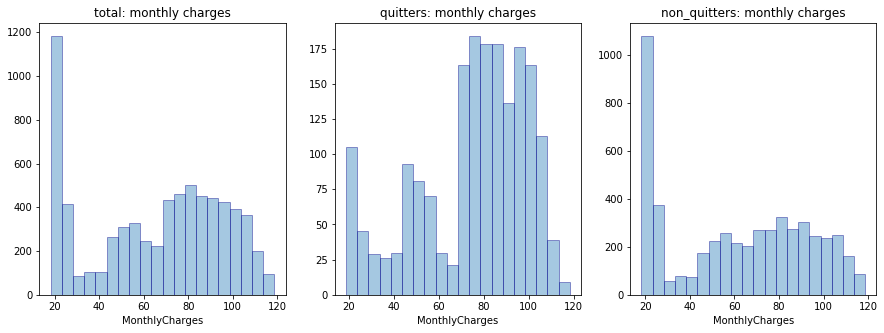

In [43]:
plt.figure(figsize=(15,5))
plt.subplot(1, 3, 1)
make_a_gist(df_contract.MonthlyCharges, 'total: monthly charges')
plt.subplot(1, 3, 2)
make_a_gist(quiters.MonthlyCharges, 'quitters: monthly charges')
plt.subplot(1, 3, 3)
make_a_gist(non_quiters.MonthlyCharges, 'non_quitters: monthly charges')

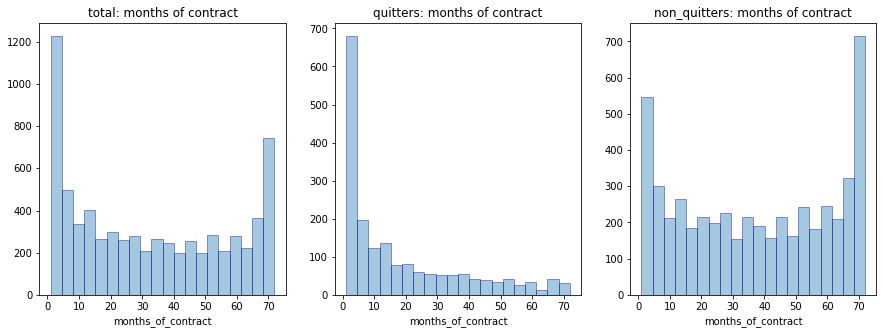

In [44]:
plt.figure(figsize=(15,5))
plt.subplot(1, 3, 1)
make_a_gist(df_contract.months_of_contract, 'total: months of contract')
plt.subplot(1, 3, 2)
make_a_gist(quiters.months_of_contract, 'quitters: months of contract')
plt.subplot(1, 3, 3)
make_a_gist(non_quiters.months_of_contract, 'non_quitters: months of contract')

Распределения ежемесячной платы имеют приблизительные очертания нормального, если отбросить увеличенное количество малых значений.  
Распрделение количества месяцев, которые клиенты пользвались услугами компании, не напоминают нормальное вообше. В случае с оставшимися клиентами значения группируются вокруг наименьших и наибольших значений, в случае с ушедшими можно говорить о постоянном уменьшении и резком количества клиентов с ростом срока.  
В целом, это наталкивает на мысль о потребительском поведении. Большинство потребителей приходило к выводу, что не хотят пользоваться услугами компании в течении 1-2 месяцев. Они пробовали, их что-то не устраивало, они тут же уходили. 
При этом, судя по распределению, большинство ушедших платили сравнительно много. 

In [45]:
df_contract[(df_contract.MonthlyCharges < 21)&df_contract.phone==True]

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,has_quitted,months_of_contract,internet,phone
11,7469-LKBCI,2018-10-01,2020-02-01,Two year,No,Credit card (automatic),18.95,326.80,False,16,False,True
16,8191-XWSZG,2015-10-01,2020-02-01,One year,No,Mailed check,20.65,1022.95,False,52,False,True
21,1680-VDCWW,2019-02-01,2020-02-01,One year,No,Bank transfer (automatic),19.80,202.25,False,12,False,True
22,1066-JKSGK,2019-11-01,2019-12-01,Month-to-month,No,Mailed check,20.15,20.15,True,1,False,True
33,7310-EGVHZ,2020-01-01,2020-02-01,Month-to-month,No,Bank transfer (automatic),20.20,20.20,False,1,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...
7005,9347-AERRL,2018-03-01,2020-02-01,One year,No,Credit card (automatic),19.30,486.20,False,23,False,True
7017,4807-IZYOZ,2015-11-01,2020-02-01,Two year,No,Bank transfer (automatic),20.65,1020.75,False,51,False,True
7019,9710-NJERN,2016-11-01,2020-02-01,Two year,No,Mailed check,20.15,826.00,False,39,False,True
7020,9837-FWLCH,2019-02-01,2020-02-01,Month-to-month,Yes,Electronic check,19.20,239.00,False,12,False,True


In [46]:
internet_users = df_contract[df_contract.internet==True]
phone_users = df_contract[df_contract.phone==True]


In [47]:
breakdown_internet = df_contract.pivot_table(index = 'internet', values = 'customerID', aggfunc = 'count')
breakdown_phone = df_contract.pivot_table(index = 'phone', values = 'customerID', aggfunc = 'count')

quiters_breakdown_internet = quiters.pivot_table(index = 'internet', values = 'customerID', aggfunc = 'count')
non_quiters_breakdown_internet = non_quiters.pivot_table(index = 'internet', values = 'customerID', aggfunc = 'count')

quiters_breakdown_phone = quiters.pivot_table(index = 'phone', values = 'customerID', aggfunc = 'count')
non_quiters_breakdown_phone = non_quiters.pivot_table(index = 'phone', values = 'customerID', aggfunc = 'count')


In [49]:
def make_a_pie(data, labels_list, title):
    plt.pie(data, labels = labels_list, autopct = '%1.1f%%')
    plt.title(title, fontsize=18)

D:\Tools\anaconda3\lib\site-packages\ipykernel_launcher.py:2: MatplotlibDeprecationWarning: Non-1D inputs to pie() are currently squeeze()d, but this behavior is deprecated since 3.1 and will be removed in 3.3; pass a 1D array instead.
  


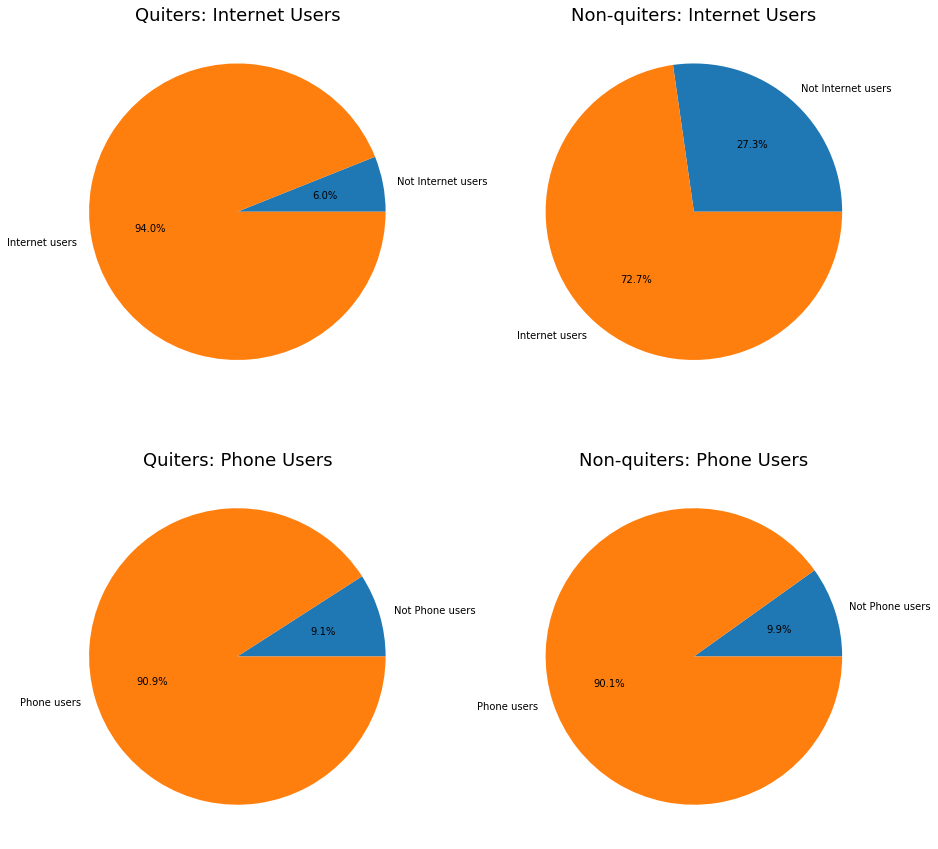

In [50]:
plt.figure(figsize=(15,15))
plt.subplot(2, 2, 1)
make_a_pie(quiters_breakdown_internet, ['Not Internet users','Internet users'], 'Quiters: Internet Users')
plt.subplot(2, 2, 2)
make_a_pie(non_quiters_breakdown_internet, ['Not Internet users','Internet users'], 'Non-quiters: Internet Users')
plt.subplot(2, 2, 3)
make_a_pie(quiters_breakdown_phone, ['Not Phone users','Phone users'], 'Quiters: Phone Users')
plt.subplot(2, 2, 4)
make_a_pie(non_quiters_breakdown_phone, ['Not Phone users','Phone users'], 'Non-quiters: Phone Users')

Интересно также, что среди оставшихся клиентов относительно велика доля не пользовавшихся нашим Интернетом пользователей, а среди ушедших доля не пользовавшихся наоборот, относительно меньше других. Это наталкивает на мысль, что один из факторов ухода могут быть какие-то претензии к нашим Интернет-услугам.

### Вывод

Стоит добавить признак, сообщающий нам о времени заключения контракта, а также признаки, по которым можно было бы сказать, пользовался потребитель интернетом/телефоном, или нет. Для интернета специального признака не надо, достаточно добавить еще одну категорию 'No' в признак 'internet service', и по этому можно будет сказать, пользовался ли потребитель интернетом или нет, посколько на данный момент все категории в этом столбце отвечают на этот вопрос утвердительно. Для телефона же потребуется отдельный признак, поскольку есть такие потребители, которые пользуются телефоном, но не пользуются многоканальной связью, и при простом объединении всех признаков из оригинальных таблиц информация о таких потребителях пропадет. 

## Подготовка данных к обучению моделей

Объединим таблицы для дальнейшей работы.

In [51]:
df = df_contract. \
 merge(df_internet, on='customerID', how='left'). \
 merge(df_phone, on='customerID', how='left'). \
 merge(df_personal, on='customerID', how='left')

In [52]:
df.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,has_quitted,months_of_contract,...,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,29.85,False,1,...,Yes,No,No,No,No,NaN,Female,0,Yes,No
1,5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,1889.50,False,34,...,No,Yes,No,No,No,No,Male,0,No,No
2,3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15,True,2,...,Yes,No,No,No,No,No,Male,0,No,No
3,7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1840.75,False,45,...,No,Yes,Yes,No,No,NaN,Male,0,No,No
4,9237-HQITU,2019-09-01,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65,True,2,...,No,No,No,No,No,No,Female,0,No,No


In [53]:
df_original = copy.deepcopy(df)


Заполним пропуски словом 'No'.

In [54]:
df = df.fillna('No')

In [55]:
df.InternetService.unique()

array(['DSL', 'Fiber optic', 'No'], dtype=object)

Прежде, чем заменить тип данных в столбцах, сделаем небольшое улучшение для удобства: поменяем регистр в названиях столбцов. Теперь, когда все признаки у нас в одной таблице, сделать это проще всего.

In [56]:
df.columns = df.columns.str.lower()

In [57]:
df.columns

Index(['customerid', 'begindate', 'enddate', 'type', 'paperlessbilling',
       'paymentmethod', 'monthlycharges', 'totalcharges', 'has_quitted',
       'months_of_contract', 'internet', 'phone', 'internetservice',
       'onlinesecurity', 'onlinebackup', 'deviceprotection', 'techsupport',
       'streamingtv', 'streamingmovies', 'multiplelines', 'gender',
       'seniorcitizen', 'partner', 'dependents'],
      dtype='object')

### Приведение к булевому типу данных

В нашем пуле будут модели, которые не принимают категориальные признаки. Благо, признаки у нас в большинстве хоть и категориальные, но бинарные, легко приводимые к булеву типу, воспинимаемому моделями, хотя и представлены в типе данных object. Приведем их к булевому типу.

Категориальных мультиклассовых признаков у нас, по сути, всего три: type, paymentnethod, internetservice. Gender бинарный признак, его спокойно можно заменить на булевый.

In [59]:
def to_bool(column_data):
    if column_data == 'Yes' or '1':
        return True
    else:
        return False

In [60]:
to_bool_columns = ['paperlessbilling', 
                   'onlinesecurity', 
                   'onlinebackup',
                   'onlinebackup',
                   'deviceprotection',
                   'techsupport',
                   'streamingtv',
                   'streamingmovies',
                   'multiplelines',
                   'seniorcitizen',
                   'partner',
                   'dependents']

In [61]:
for i in to_bool_columns:
    df[i] = df[i].apply(to_bool)

In [62]:
df['gender_is_female'] = df.gender == 'Female'
df = df.drop('gender', axis = 1)

In [63]:
df.head()

,customerid,begindate,enddate,type,paperlessbilling,paymentmethod,monthlycharges,totalcharges,has_quitted,months_of_contract,...,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies,multiplelines,seniorcitizen,partner,dependents,gender_is_female
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,True,Electronic check,29.85,29.85,False,1,...,True,True,True,True,True,True,True,True,True,True
1,5575-GNVDE,2017-04-01,2020-02-01,One year,True,Mailed check,56.95,1889.50,False,34,...,True,True,True,True,True,True,True,True,True,False
2,3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,True,Mailed check,53.85,108.15,True,2,...,True,True,True,True,True,True,True,True,True,False
3,7795-CFOCW,2016-05-01,2020-02-01,One year,True,Bank transfer (automatic),42.30,1840.75,False,45,...,True,True,True,True,True,True,True,True,True,False
4,9237-HQITU,2019-09-01,2019-11-01,Month-to-month,True,Electronic check,70.70,151.65,True,2,...,True,True,True,True,True,True,True,True,True,True


### Масштабирование, кодирование и подготовка выборок

Нам осталось закодировать всего три признака.

In [66]:
object_columns = ['type','paymentmethod','internetservice']

In [67]:
[print(f'{col_name}: {df[col_name].unique()}') for col_name in object_columns]

type: ['Month-to-month' 'One year' 'Two year']
paymentmethod: ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']
internetservice: ['DSL' 'Fiber optic' 'No']


[None, None, None]

Перед тем, как закодировать категориальные данные, отмасштабируем количественные.

In [68]:
scaler = StandardScaler()
numeric = ['monthlycharges','totalcharges','months_of_contract']
scaler.fit(df[numeric])

StandardScaler()

In [69]:
df_scaled = copy.deepcopy(df)
df_scaled[numeric] = scaler.transform(df[numeric])

In [70]:
df_scaled.head()

,customerid,begindate,enddate,type,paperlessbilling,paymentmethod,monthlycharges,totalcharges,has_quitted,months_of_contract,...,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies,multiplelines,seniorcitizen,partner,dependents,gender_is_female
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,True,Electronic check,-1.161694,-0.994194,False,-1.280248,...,True,True,True,True,True,True,True,True,True,True
1,5575-GNVDE,2017-04-01,2020-02-01,One year,True,Mailed check,-0.260878,-0.173740,False,0.064303,...,True,True,True,True,True,True,True,True,True,False
2,3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,True,Mailed check,-0.363923,-0.959649,True,-1.239504,...,True,True,True,True,True,True,True,True,True,False
3,7795-CFOCW,2016-05-01,2020-02-01,One year,True,Bank transfer (automatic),-0.747850,-0.195248,False,0.512486,...,True,True,True,True,True,True,True,True,True,False
4,9237-HQITU,2019-09-01,2019-11-01,Month-to-month,True,Electronic check,0.196178,-0.940457,True,-1.239504,...,True,True,True,True,True,True,True,True,True,True


Caboost'у мы можем передать и категориальные признаки, для леса и для логистической регрессии подготовим ohe-данные, для lightgmb и random_forest применим порядковое кодирование данных.

In [71]:
features = df_scaled.drop(['customerid','begindate','internet', 'enddate','has_quitted'], axis = 1)

In [72]:
features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7031
Data columns (total 19 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   type                7032 non-null   object 
 1   paperlessbilling    7032 non-null   bool   
 2   paymentmethod       7032 non-null   object 
 3   monthlycharges      7032 non-null   float64
 4   totalcharges        7032 non-null   float64
 5   months_of_contract  7032 non-null   float64
 6   phone               7032 non-null   bool   
 7   internetservice     7032 non-null   object 
 8   onlinesecurity      7032 non-null   bool   
 9   onlinebackup        7032 non-null   bool   
 10  deviceprotection    7032 non-null   bool   
 11  techsupport         7032 non-null   bool   
 12  streamingtv         7032 non-null   bool   
 13  streamingmovies     7032 non-null   bool   
 14  multiplelines       7032 non-null   bool   
 15  seniorcitizen       7032 non-null   bool   
 16  partne

In [73]:
target = df_scaled.has_quitted

In [74]:
features_train, features_test, target_train, target_test = train_test_split(features, target, 
                                                                                test_size = 0.25, 
                                                                                stratify = target,
                                                                                random_state = state)

In [75]:
[print(f'{col_name}: {df[col_name].unique()}') for col_name in object_columns]

type: ['Month-to-month' 'One year' 'Two year']
paymentmethod: ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']
internetservice: ['DSL' 'Fiber optic' 'No']


[None, None, None]

In [76]:
features_ohe = pd.get_dummies(features)

In [77]:
features_ohe.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7031
Data columns (total 26 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   paperlessbilling                         7032 non-null   bool   
 1   monthlycharges                           7032 non-null   float64
 2   totalcharges                             7032 non-null   float64
 3   months_of_contract                       7032 non-null   float64
 4   phone                                    7032 non-null   bool   
 5   onlinesecurity                           7032 non-null   bool   
 6   onlinebackup                             7032 non-null   bool   
 7   deviceprotection                         7032 non-null   bool   
 8   techsupport                              7032 non-null   bool   
 9   streamingtv                              7032 non-null   bool   
 10  streamingmovies                          7032 no

In [78]:
features_ohe_train, features_ohe_test, target_ohe_train, target_ohe_test = train_test_split(features_ohe, target, 
                                                                                test_size = 0.25, 
                                                                                stratify = target,
                                                                                random_state = state)

In [80]:
df_ordin = copy.deepcopy(df_scaled)
ordin = OrdinalEncoder()
df_ordin[object_columns] = ordin.fit_transform(df[object_columns])

In [81]:
features_ordin = df_ordin.drop(['customerid','begindate','internet', 'enddate','has_quitted'], axis = 1)
target_ordin = df_ordin.has_quitted

In [82]:
features_ordin_train, features_ordin_test, target_ordin_train, target_ordin_test = train_test_split(features_ordin, target_ordin, 
                                                                                test_size = 0.25, 
                                                                                stratify = target,
                                                                                random_state = state)

### Логистическая регрессия

In [84]:
num_folds = 5

In [85]:
logreg = LogisticRegression()

In [86]:
logreg_cv = cross_validate(logreg, features_ohe_train, target_ohe_train, scoring = ['roc_auc', 'accuracy'], cv = num_folds, verbose=0) 

In [87]:
logreg_cv

{'fit_time': array([0.02991891, 0.02593017, 0.02792525, 0.03091741, 0.02892303]),
 'score_time': array([0.00498843, 0.00498676, 0.00398898, 0.0039885 , 0.00498891]),
 'test_roc_auc': array([0.82895853, 0.84482488, 0.83772656, 0.83994501, 0.83243125]),
 'test_accuracy': array([0.77630332, 0.80473934, 0.79241706, 0.79241706, 0.79601518])}

In [88]:
logreg_roc_auc = logreg_cv['test_roc_auc'].mean()
logreg_acc = logreg_cv['test_accuracy'].mean()

In [89]:
logreg_roc_auc 

0.8367772451564848

In [90]:
logreg_acc

0.7923783915033678

### Случайный лес

In [92]:
def forest_search(X, y, forest_depth_range, forest_estimators_range, n_folds):
    forest_depth_col = []
    forest_estim_col = []
    forest_roc_auc_col = []
    forest_acc_col = []
    for depth in forest_depth_range:
        for n_estim in forest_estimators_range:
            forest_model = RandomForestClassifier(n_estimators = n_estim, 
                                                   max_depth = depth, 
                                                   random_state = state)
            forest_cv = cross_validate(forest_model, X, y, scoring = ['roc_auc', 'accuracy'], cv = n_folds, verbose=0) 
            forest_roc_auc = forest_cv['test_roc_auc'].mean()
            forest_acc = forest_cv['test_accuracy'].mean()
            forest_depth_col.append(depth)
            forest_estim_col.append(n_estim)
            forest_roc_auc_col.append(forest_roc_auc)
            forest_acc_col.append(forest_acc)
    forest_hyperparameters_dict = {'max_depth': forest_depth_col, 'n_estimators': forest_estim_col,'roc_auc': forest_roc_auc_col, 'accuracy': forest_acc_col}
    forest_hyperparameters = pd.DataFrame(data = forest_hyperparameters_dict)
    return forest_hyperparameters

In [93]:
forest_depth_range = [12,18,26,50]
forest_estimators_range = [80, 120,160]
n_folds = 5

In [94]:
%%time
forest_results = forest_search(features_ordin_train, target_ordin_train, forest_depth_range, forest_estimators_range, n_folds)

Wall time: 21 s


In [95]:
forest_results

,max_depth,n_estimators,roc_auc,accuracy
0,12,80,0.824690,0.787447
1,12,120,0.824802,0.788774
2,12,160,0.824686,0.788394
3,18,80,0.808869,0.780430
4,18,120,0.809990,0.777395
5,18,160,0.810662,0.778154
6,26,80,0.808051,0.781757
7,26,120,0.808832,0.779104
8,26,160,0.808971,0.778724
9,50,80,0.807760,0.781568


In [96]:
forest_best_hyper = forest_results.sort_values(by = 'roc_auc', ascending = False).head(1)

In [97]:
forest_best_depth = int(forest_best_hyper['max_depth'])
forest_best_n_estimators = int(forest_best_hyper['n_estimators'])

In [98]:
forest_best_hyper

,max_depth,n_estimators,roc_auc,accuracy
1,12,120,0.824802,0.788774


### CatBoost

In [100]:
%%time
def catboost_cv(X, y, n_iterations, depth, learn_rate, l2_leaf_reg, n_folds):
    params = {'iterations': n_iterations,
              'depth': depth,
              'learning_rate': learn_rate,
              'l2_leaf_reg': l2_leaf_reg,
              'loss_function': 'Logloss',
              'custom_metric': ['AUC', 'Accuracy'], 
              'random_state': state, 
              'verbose': 0}
    pool = Pool(X, label=y, cat_features=object_columns)
    cv_data = cv(
        params = params,
        pool = pool,
        fold_count=n_folds,
        inverted=False,
        shuffle=True,
        stratified=True,
        partition_random_seed=state)
    top_value = np.max(cv_data['test-AUC-mean'])
    top_iter = np.argmax(cv_data['test-AUC-mean'])
    top_result = cv_data.loc[top_iter, :]
    top_acc = top_result['test-Accuracy-mean']
    return cv_data, top_value, top_iter, top_result, top_acc

Wall time: 0 ns


In [101]:
def catboost_search(X_search, y_search):
    learning_rate_col = []
    depth_col = []
    l2_leaf_reg_col = []
    iterations_col = []
    roc_auc_col = []
    acc_col = []
    on_step_col = []
    for n_iterations in iterations_range:
        for learn_rate in learn_rate_range:
            for l2_leaf_reg in l2_leaf_reg_range:
                for depth in depth_range:
                    catbo_cv_data, catbo_top_value, catbo_top_iter, catbo_top_result, catbo_top_acc = catboost_cv(X_search, 
                                                                                                                  y_search,
                                                                                                                  n_iterations, 
                                                                                                                  depth, 
                                                                                                                  learn_rate, 
                                                                                                                  l2_leaf_reg, 
                                                                                                                  n_folds)
                    depth_col.append(depth)
                    l2_leaf_reg_col.append(l2_leaf_reg)
                    learning_rate_col.append(learn_rate)
                    iterations_col.append(n_iterations)
                    roc_auc_col.append(catbo_top_value)
                    acc_col.append(catbo_top_acc)
                    on_step_col.append(catbo_top_iter)
    catboost_hyperparameters_dict = {'depth': depth_col, 
                                     'l2_leaf_reg': l2_leaf_reg_col, 
                                     'learning_rate': learning_rate_col, 
                                     'iterations': iterations_col, 
                                     'roc_auc': roc_auc_col, 
                                     'accuracy': acc_col, 'on_step': on_step_col}
    
    catboost_hyperparameters = pd.DataFrame(data = catboost_hyperparameters_dict)
    return catboost_hyperparameters                

In [102]:
iterations_range = [500, 2000]
learn_rate_range = [0.005, 0.01]
l2_leaf_reg_range = [12]
depth_range = [6]
n_folds = 5

In [103]:
%%time

catboost_results= catboost_search(features_train, target_train)

Wall time: 6min 5s


In [104]:
catboost_results

,depth,l2_leaf_reg,learning_rate,iterations,roc_auc,accuracy,on_step
0,6,12,0.005,500,0.840872,0.796365,499
1,6,12,0.010,500,0.842587,0.798830,497
2,6,12,0.005,2000,0.843350,0.795796,1694
3,6,12,0.010,2000,0.843055,0.793900,885


In [105]:
catboost_best_hyper = catboost_results.sort_values(by = 'roc_auc',ascending = False).head(1)

In [106]:
catboost_best_hyper

,depth,l2_leaf_reg,learning_rate,iterations,roc_auc,accuracy,on_step
2,6,12,0.005,2000,0.84335,0.795796,1694


In [107]:
catboost_best_depth = int(catboost_best_hyper['depth'])
catboost_best_l2_leaf_reg = int(catboost_best_hyper['l2_leaf_reg'])
catboost_best_learning_rate = float(catboost_best_hyper['learning_rate'])
catboost_best_iterations = int(catboost_best_hyper['iterations'])

In [108]:
catbo_best_model = CatBoostClassifier(iterations= catboost_best_iterations,
                                 depth= catboost_best_depth,
                                 learning_rate= catboost_best_learning_rate,
                                 l2_leaf_reg= catboost_best_l2_leaf_reg, 
                                 loss_function= 'Logloss',
                                 custom_metric= ['AUC', 'Accuracy'], 
                                 random_state= state, 
                                 verbose= 0)

In [109]:
%%time
catbo_best_model.fit(features_train,target_train,cat_features = object_columns)

Wall time: 12.5 s


In [110]:
%%time
feature_importance = catbo_best_model.get_feature_importance(data=Pool(features_train, label=target_train, cat_features=object_columns),
                                                        type = 'FeatureImportance',
                                                        prettified=True,
                                                        thread_count=-1,
                                                        verbose=False)

Wall time: 102 ms


In [111]:
feature_importance 

,Feature Id,Importances
0,type,26.470802
1,internetservice,22.931070
2,months_of_contract,19.451257
3,monthlycharges,10.018693
4,totalcharges,9.091256
5,paymentmethod,6.503979
6,phone,2.879711
7,gender_is_female,2.653232
8,paperlessbilling,0.000000
9,onlinesecurity,0.000000


Интересно посмотреть, какие признаки оказались наиболее важными для классификации. Созданный нами признак months of contract, отражающий жизненный цикл потребителя в месяцах, оказался очень важным и входит тройку по вкладу в обучение модели.  
Также стоит заметить, что важнейшими факторами оказались тип контракта и способ подключения.

Иногда алгоритм CatBoost показывает лучший результат, если ей передать данные с закодированными категориальными признаками. Проверим. 

In [112]:
%%time
def catboost_ohe_cv(X, y, n_iterations, depth, learn_rate, l2_leaf_reg, n_folds):
    ohe_params = {'iterations': n_iterations,
              'depth': depth,
              'learning_rate': learn_rate,
              'l2_leaf_reg': l2_leaf_reg,
              'loss_function': 'Logloss',
              'custom_metric': ['AUC', 'Accuracy'], 
              'random_state': state, 
              'verbose': 0}
    ohe_pool = Pool(X, label=y)
    ohe_cv_data = cv(
        params = ohe_params,
        pool = ohe_pool,
        fold_count=n_folds,
        inverted=False,
        shuffle=True,
        stratified=True,
        partition_random_seed=state)
    ohe_top_value = np.max(ohe_cv_data['test-AUC-mean'])
    ohe_top_iter = np.argmax(ohe_cv_data['test-AUC-mean'])
    ohe_top_result = ohe_cv_data.loc[ohe_top_iter, :]
    ohe_top_acc = ohe_top_result['test-Accuracy-mean']
    return ohe_cv_data, ohe_top_value, ohe_top_iter, ohe_top_result, ohe_top_acc

Wall time: 0 ns


In [113]:
def catboost_ohe_search(X_ohe_search, y_ohe_search):
    ohe_learning_rate_col = []
    ohe_depth_col = []
    ohe_l2_leaf_reg_col = []
    ohe_iterations_col = []
    ohe_roc_auc_col = []
    ohe_acc_col = []
    ohe_on_step_col = []
    for n_iterations in iterations_range:
        for learn_rate in learn_rate_range:
            for l2_leaf_reg in l2_leaf_reg_range:
                for depth in depth_range:
                    catbo_cv_ohe_data, catbo_top_ohe_value, catbo_top_ohe_iter, catbo_top_ohe_result, catbo_top_ohe_acc = catboost_ohe_cv(X_ohe_search, 
                                                                                                                  y_ohe_search,
                                                                                                                  n_iterations, 
                                                                                                                  depth, 
                                                                                                                  learn_rate, 
                                                                                                                  l2_leaf_reg, 
                                                                                                                  n_folds)
                    ohe_depth_col.append(depth)
                    ohe_l2_leaf_reg_col.append(l2_leaf_reg)
                    ohe_learning_rate_col.append(learn_rate)
                    ohe_iterations_col.append(n_iterations)
                    ohe_roc_auc_col.append(catbo_top_ohe_value)
                    ohe_acc_col.append(catbo_top_ohe_acc)
                    ohe_on_step_col.append(catbo_top_ohe_iter)
    ohe_catboost_hyperparameters_dict = {'depth': ohe_depth_col, 
                                     'l2_leaf_reg': ohe_l2_leaf_reg_col, 
                                     'learning_rate': ohe_learning_rate_col, 
                                     'iterations': ohe_iterations_col, 
                                     'roc_auc': ohe_roc_auc_col, 
                                     'accuracy': ohe_acc_col, 'on_step': ohe_on_step_col}
    
    ohe_catboost_hyperparameters = pd.DataFrame(data = ohe_catboost_hyperparameters_dict)
    return ohe_catboost_hyperparameters                

In [114]:
%%time

catboost_ohe_results= catboost_ohe_search(features_ohe_train, target_ohe_train)

Wall time: 4min 18s


In [115]:
catboost_ohe_results

,depth,l2_leaf_reg,learning_rate,iterations,roc_auc,accuracy,on_step
0,6,12,0.005,500,0.841868,0.795796,498
1,6,12,0.010,500,0.842429,0.797692,387
2,6,12,0.005,2000,0.842533,0.796743,890
3,6,12,0.010,2000,0.842429,0.797692,387


In [116]:
catboost_ohe_best_hyper = catboost_ohe_results.sort_values(by = 'roc_auc',ascending = False).head(1)

In [117]:
catboost_ohe_best_hyper

,depth,l2_leaf_reg,learning_rate,iterations,roc_auc,accuracy,on_step
2,6,12,0.005,2000,0.842533,0.796743,890


In [118]:
catboost_ohe_best_depth = int(catboost_ohe_best_hyper['depth'])
catboost_ohe_best_l2_leaf_reg = int(catboost_ohe_best_hyper['l2_leaf_reg'])
catboost_ohe_best_learning_rate = float(catboost_ohe_best_hyper['learning_rate'])
catboost_ohe_best_iterations = int(catboost_ohe_best_hyper['iterations'])

In [119]:
catbo_ohe_best_model = CatBoostClassifier(iterations= catboost_ohe_best_iterations,
                                 depth= catboost_ohe_best_depth,
                                 learning_rate= catboost_ohe_best_learning_rate,
                                 l2_leaf_reg= catboost_ohe_best_l2_leaf_reg, 
                                 loss_function= 'Logloss',
                                 custom_metric= ['AUC', 'Accuracy'], 
                                 random_state= state, 
                                 verbose= 0)

### LightGBM

In [121]:
def lightgbm_cv(X, y, n_iterations, depth, learn_rate, l2_leaf_reg, n_folds):
    lgbm_model = LGBMClassifier(objective="binary", eval_metric=['AUC', 'Accuracy'],
                                                     iterations = n_iterations,
                                                      max_depth = depth,
                                                       reg_lambda = l2_leaf_reg,
                                                       learning_rate = learn_rate,
                                                       random_state = state)
    lgbm_cv_result = cross_validate(lgbm_model, X, y, 
                                    scoring = ['roc_auc', 'accuracy'], 
                                    cv = num_folds, verbose=0) 
    lgbm_auc = lgbm_cv_result['test_roc_auc'].mean()
    lgbm_acc = lgbm_cv_result['test_accuracy'].mean()
    return lgbm_cv_result, lgbm_auc, lgbm_acc  
    

In [122]:
def lightgbm_search(X_search, y_search):
    learning_rate_col = []
    max_depth_col = []
    reg_lambda_col = []
    iterations_col = []
    lgbm_auc_col = []
    lgbm_acc_col = []
    for depth in depth_range:
        for reg_lambda in l2_leaf_reg_range:
            for learn_rate in learn_rate_range:
                for iterations in iterations_range:
                    lgbm_cv_result, lgbm_top_auc, lgbm_top_acc = lightgbm_cv(X_search, y_search,
                                                               iterations,
                                                               depth, 
                                                               learn_rate, 
                                                               reg_lambda, 
                                                               n_folds)
                    max_depth_col.append(depth)
                    reg_lambda_col.append(reg_lambda)
                    learning_rate_col.append(learn_rate)
                    iterations_col.append(iterations)
                    lgbm_auc_col.append(lgbm_top_auc)
                    lgbm_acc_col.append(lgbm_top_acc)
    LGBM_hyperparameters_dict = {'max_depth': max_depth_col, 
                                     'reg_lambda': reg_lambda_col, 
                                     'learning_rate': learning_rate_col, 
                                     'iterations': iterations_col, 
                                     'roc_auc': lgbm_auc_col,'accuracy': lgbm_acc_col}
    LGBM_hyperparameters = pd.DataFrame(data = LGBM_hyperparameters_dict)
    return LGBM_hyperparameters               
    

In [123]:
iterations_range = [500, 2000]
learn_rate_range = [0.005, 0.01]
l2_leaf_reg_range = [8,12]
depth_range = [6,8]
n_folds = 5

In [124]:
%%time
lgbm_results = lightgbm_search(features_ordin_train, target_ordin_train)

Wall time: 4.75 s


In [125]:
lgbm_results

,max_depth,reg_lambda,learning_rate,iterations,roc_auc,accuracy
0,6,8,0.005,500,0.830732,0.734168
1,6,8,0.005,2000,0.830732,0.734168
2,6,8,0.010,500,0.834624,0.780433
3,6,8,0.010,2000,0.834624,0.780433
4,6,12,0.005,500,0.829162,0.734168
5,6,12,0.005,2000,0.829162,0.734168
6,6,12,0.010,500,0.834633,0.778725
7,6,12,0.010,2000,0.834633,0.778725
8,8,8,0.005,500,0.829966,0.734168
9,8,8,0.005,2000,0.829966,0.734168


In [126]:
lgbm_best_hyper = lgbm_results.sort_values(by = 'roc_auc',ascending = False).head(1)

In [127]:
lgbm_best_hyper

,max_depth,reg_lambda,learning_rate,iterations,roc_auc,accuracy
14,8,12,0.01,500,0.834686,0.779105


In [128]:
lgbm_best_depth = int(lgbm_best_hyper['max_depth'])
lgbm_best_reg_lambda = int(lgbm_best_hyper['reg_lambda'])
lgbm_best_learning_rate = float(lgbm_best_hyper['learning_rate'])
lgbm_best_iterations = int(lgbm_best_hyper['iterations'])

### Вывод

In [129]:
results_df = pd.DataFrame(data = {'model':['logreg', 'forest', 'catboost', 'catboost ohe', 'lgbm'],
                                  'roc_auc':[logreg_roc_auc, 
                                             float(forest_best_hyper.roc_auc), 
                                             float(catboost_best_hyper.roc_auc), 
                                             float(catboost_ohe_best_hyper.roc_auc),
                                             float(lgbm_best_hyper.roc_auc)],
                                  'accuracy':[logreg_acc,
                                              float(forest_best_hyper.accuracy),
                                              float(catboost_best_hyper.accuracy),
                                              float(catboost_ohe_best_hyper.accuracy),
                                              float(lgbm_best_hyper.accuracy)]})

In [130]:
results_df

,model,roc_auc,accuracy
0,logreg,0.836777,0.792378
1,forest,0.824802,0.788774
2,catboost,0.843350,0.795796
3,catboost ohe,0.842533,0.796743
4,lgbm,0.834686,0.779105


In [131]:
results_df[results_df.roc_auc==results_df.roc_auc.max()]

,model,roc_auc,accuracy
2,catboost,0.84335,0.795796


Самый высокий показатель roc-auc продемонстрировала модель на CatBoost с не кодированными категориальными признаками. 

## Тестирование

Мы выбрали алгоритм и определили гиперпараметры модели. Осталось получить результаты на тестовой выборке.

In [133]:
catboost_best_model = CatBoostClassifier(iterations= catboost_best_iterations,
                                 depth= catboost_best_depth,
                                 learning_rate= catboost_best_learning_rate,
                                 l2_leaf_reg= catboost_best_l2_leaf_reg, 
                                 loss_function= 'Logloss',
                                 custom_metric= ['AUC', 'Accuracy'], 
                                 random_state= state, 
                                 verbose= 0)

In [134]:
%%time
catboost_best_model.fit(features_train, target_train, cat_features = object_columns)

Wall time: 12.8 s


In [135]:
catboost_predicted_test = catboost_best_model.predict(features_test)
catboost_predicted_test = pd.Series(catboost_predicted_test).replace(to_replace = ['True','False'],value = [True,False])
catboost_predict_proba_test = catboost_best_model.predict_proba(features_test)
catboost_predict_proba_one_test = catboost_predict_proba_test[:, 1]

In [136]:
catboost_roc_auc_test = roc_auc_score(target_test, catboost_predict_proba_one_test)
catboost_acc_test = accuracy_score(target_test, catboost_predicted_test)

In [137]:
print('ROC-AUC:',catboost_roc_auc_test)
print('Accuracy:',catboost_acc_test)

ROC-AUC: 0.845444578427161
Accuracy: 0.7986348122866894


Мы получили значение ключевой метрики ROC-AUC на тестовой выборке выше необходимого порога. Значение метрики accuracy так же выведено.  
Задание выполнено.

In [138]:
%%time
feature_importance_test = catboost_best_model.get_feature_importance(data=Pool(features_test, label=target_test, cat_features=object_columns),
                                                        type = 'FeatureImportance',
                                                        prettified=True,
                                                        thread_count=-1,
                                                        verbose=False)


Wall time: 44.9 ms


In [139]:
def importance_bars(feature_importance_test):
    feature_importance_test = feature_importance_test.sort_values(by = 'Importances')
    labels = feature_importance_test['Feature Id']
    value = feature_importance_test['Importances'].values
    position = np.arange(len(feature_importance_test))
    fig, ax = plt.subplots()
    ax.barh(position, value, alpha = 0.7, color = 'slateblue', edgecolor = 'darkblue')
    ax.set_yticks(position)
    ax.set_yticklabels(labels,
                   fontsize = 15)
    ax.grid()
    plt.title('Feature importance (per cent)',fontsize = 20)
    fig.set_figwidth(10)
    fig.set_figheight(6)
    plt.show()

## Отчет

Перед началом разработки модели на основе предварительного исследования данных с руководителем группы был согласован следующий план:

1) Обработать данные.
    - В датафрейме contract необходимо заменить типы данных в столбцах BeginDate, TotalCharges; 
    - EndDate стоит обработать, возможно, имеет смысл создать столбец с булевыми значениями, а в самом столбце EndDate заменить значения No на первое февраля 2020;
    - В столбце TotalCharges есть пропуски, замаскированные под пробелы и потому не определяющиеся методом info(); возможно, пропуски есть и в других столбцах и датафреймах;
    - Для удобства стоит поменять регистр в названиях стобцов;
    - Следует объединить таблицы по признаку customerID.
2) Исследовать данные.
    - В распределении MonthlyChanges есть увеличенное количество клиентов с ежемесячными выплатами до 21, они занимают большой процент от выборки. Изучить подробнее на возможность ошибки/аномалии.
    - Изучить возможность зависимости между разными услугами, способами оплаты и типом договора и ежемесячным платежом и фактом ухода; Возможно, стоит отбросить часть маловлияющих на вероятность ухода признаков ради скорости обучения модели; 
3) Обучить модель.
    - Задача классификации, поэтому стоит привести целевой признак в соответствующую форму;
    - Порядок объектов не играет роли, поэтому, возможно, имеет смысл прибегнуть к кросс-валидации;
    - Возможно, имеет смысл рассчитать для пользователей длительность контракта и использовать его как признак (aka жизненный цикл потребителя)
    - Попробовать логистическую регрессию, случайный лес и градиентный бустинг; перебрать гиперпараметры;
4) Протестировать модель.
    - Выделить тестовую часть выборки и проверить на ней;
    - Ключевая метрика - roc-auc.
    

Все пункты плана были выполнены. Более подробное описание результата работы над каждым пунктом плана:

1) Обработать данные.
    - В датафрейме contract необходимо заменить типы данных в столбцах BeginDate, TotalCharges;  
**Типы данных в BeginDate, EndDate и TotalCharges заменены на подходящие datetime, datetime и int соответственно. Так же после объединения датафреймов в один типы данных всех бинарных категориальных признаков были приведены к булевому типу.**  
    - EndDate стоит обработать, возможно, имеет смысл создать столбец с булевыми значениями, а в самом столбце EndDate заменить значения No на первое февраля 2020;  
**На основе факта отсутсвия/наличия даты завершения контракта в столбце EndDate был создан бинарный категориальный признак has_quitted с типом данных bool, который впоследствии использовался как целевой, а кроме того служил для исследовательского анализа (деление объектов на ушедших и оставшихся клиентов).**  
**После этого значения 'No' в столбце EndDate были заменены на дату 2020-02-01, а столбец приведен в datetime, что позволило рассчитать количество месяцов от начала контракта до конца контракта для ушедших и до даты выгрузки для оставшихся клиентов и создать количественный признак months_of_contract, отражающий информацию о жизненном цикле потребителя. Впоследствии признак продемонстрировал себя нужным и важным для обучения модели (см. график 'feature importance' ниже).**  
    - В столбце TotalCharges есть пропуски, замаскированные под пробелы и потому не определяющиеся методом info(); возможно, пропуски есть и в других столбцах и датафреймах;  
**Изначально планировалось заполнить пропуски в TotalCharges, рассчитав сумму платежей умножением ежемесячных платежей на количество месяцев действия контракта months_of_contract. Однако в ходе этого выяснилось, что все данные с пропущенным значением описывают клиентов, попавших в базу в день выгрузки. Произведенные ими платежи равнялись нулю - видимо, оплата за месяц производится не в первый день, или же информация о платеже еще не была внесена в базу - поэтому несмотря на указанный monthlycharges, их totalcharges были пропущены, и пропуски были оформлены пробелами.**
**Большая часть информации по объектам наличествовала, однако информация по их жизненному цкиклу как потребителей была не валидна, поскольку они еще не успели побывать в статусе потребителей компании, и использование их в анализе могло, хоть и незначительно, но отрицательно сказаться на качестве модели. Впрочем, главным агрументом удаления их из базы является тот факт, что их всего 11, поэтому их можно было без какого-либо риска удалить из выборки.**
    - Для удобства стоит поменять регистр в названиях стобцов;
**Изменение регистра было сделано после объединения всех датафреймов в один, чтобы накрыть все цели (все столбцы) разом.**
    - Следует объединить таблицы по признаку customerID.
**Таблицы были объединены в один датафрейм, который затем использовался для обучения модели, чтобы все признаки из всех таблиц были отданы модели, но это не все. Перед объединением были созданы бинарные категориальные признаки internet и phone, отражающие, подключил ли пользователь интернет или нет. В случае с интернетом этот признак был впоследствии удален, поскольку при объединении таблиц в столбце internetservice помимо наличествующих там категорий появились пропуски, которые были превращены в категорию 'No', и вместе эти категории передавали информацию, был ли у пользователя контракт на интернет, или нет. В случае с телефонией по единственному признаку multiplelines сказать о наличии соглашения о телефоне нельзя, поскольку были и пользователи, которые подключили телефонию, но не пользуются многоканальной связью, поэтому признак phone был оставлен.**  

2) Исследовать данные.
    - В распределении MonthlyChanges есть увеличенное количество клиентов с ежемесячными выплатами до 21, они занимают большой процент от выборки. Изучить подробнее на возможность ошибки/аномалии.
**Было принято решение не удалять данные, поскольку, во-первых, какого-то четкого основания для этого нет, во-вторых, жертововать сравнительно большой частью выборки было нежелательно.**  
    - Изучить возможность зависимости между разными услугами, способами оплаты и типом договора и ежемесячным платежом и фактом ухода; Возможно, стоит отбросить часть маловлияющих на вероятность ухода признаков ради скорости обучения модели;  
**Скорость обучения модели оказалась не настолько малой, чтобы возникла необходимость отбрасывать какие-то признаки, хотя модель выявила, что для ее обучения большая часть признаков оказалась не важной. Однако признаки EndDate и BeginDate были исключены из-за возможности утечки целевого признака.**
**Тип договора оказался важнейшим фактором, влияющим на вероятность ухода (см. график 'feature importance' ниже). Способ оплаты оказал не такой вклад в обучение модели, но все же входит в пятерку важнейших факторов. Так же в ходе исследовательского анализа было высказано предположение о влиянии факторов, сязанных с интернет-услугами, на уход (точнее, на вероятность остаться), поскольку доля не пользующихся интернетом клиентов среди ушедших была высока. Модель выявила влияние этого фактора - internetservices, в котором помимо указания способа подключения стала содержаться и информация, пользовался ли клиент интернетом, или нет, является вторым по важности фактором.**  

3) Обучить модель.
    - Задача классификации, поэтому стоит привести целевой признак в соответствующую форму;  
**Целевым признаком стал признак has_quitted.**  
    - Порядок объектов не играет роли, поэтому, возможно, имеет смысл прибегнуть к кросс-валидации;  
**Кросс-валидация была применена в обучении всех моделей.**  
    - Возможно, имеет смысл рассчитать для пользователей длительность контракта и использовать его как признак (aka жизненный цикл потребителя)  
**Длительность контракта в месяцах была рассчитана и оказалась третьим по важности фактором.**
    - Попробовать логистическую регрессию, случайный лес и градиентный бустинг; перебрать гиперпараметры;
**Логистическая регрессия и случайный лес были обучены и опробованы, градиентный бустинг был опробован на алгоритмах CatBoost и LightGBM; перебор гиперпараметров для леса и градиентного бустинга был осуществлен.**  
4) Протестировать модель.
    - Выделить тестовую часть выборки и проверить на ней;  
**Результат предсказания модели на тестовой выборке - ниже.**  
    - Ключевая метрика - roc-auc.
**Также по распоряжению руководителя была определена метрика accuracy.**
    

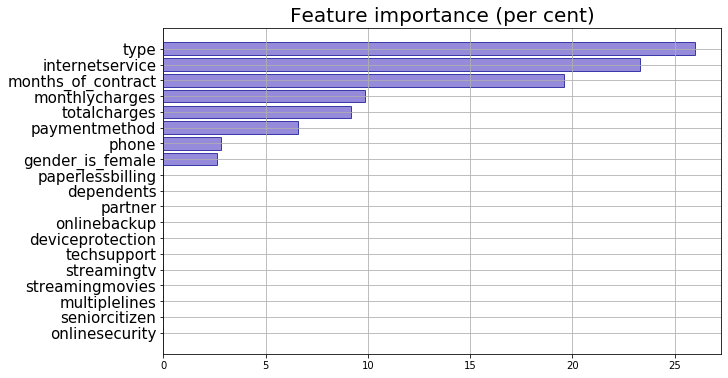

In [140]:
importance_bars(feature_importance_test)

В ходе работы возникли трудности.  

Первоначально во время предобработки данных были выявлены пропуски в TotalCharges. Как было отмечено выше, были основания считать объекты с пропусками невалидными по одному важному признаку (жизненный цикл) и малочисленными, они были удалены.  

Возник теоретический вопрос о корректности использования данных об объектах, заключивших контракт незадолго до даты выгрузки и еще не разорвавших его. Было предположение, что их включение в датасет мог привести к увеличению ложно-положительных предсказаний, поскольку клиенты могут уйти вскоре после даты выгрузки, но модель сочтет их лояльными, поскольку они еще не успели уйти, и сделает неправильные заключения о жизненном цикле клиента. Однако, во-первых, их исключение приводило к слишком большой потере выборки (если бы мы исключили не ушедших клиентов со сроком контракта меньшим или равным медианному сроку разорванных контрактов, мы бы потеряли около 15% общей выборки), а во-вторых, их исключение с тем же успехом могло бы сповоцировать увеличение ложно-отрицательных предсказаний в будущем, поскольку модель бы определяла как оставшихся __только__ клиентов с большим количеством месяцев контракта. 

Ключевым шагом решения задачи стало использование begindate и enddate для создания признака month_of_contract, а так же создание признаков has_quitted и phone. Has_quitted послужил целевым признаком, а остальные вошли в число факторов, внесших вклад в обучение модели, а month_of_contact оказалась в лидирующей с большим отрывом тройке самых важных факторов.  
Кроме того ключевым, хотя и довольно очевидным, решением можно назвать перевод большего числа категориальных признаков в булев формат, что заметно должно было ускорить обучение моделей.
Также ключевым решением в решении было использования кросс-валидации как принципа и CatBoost как средства создания модели. 

Классификатор CatBoost продемонстрировал отличное качество модели, кроме того, с библиотекой CatBoost оказалось сравнительно удобно работать, хотя время обучения с учетом перебора параметров было выше, чем у других алгоритмов. Тем не менее, ограничения по времени работы модели не было, поэтому модель отбиралась по показателю метрики roc-auc.  

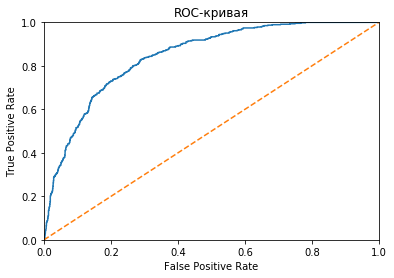

In [141]:
fpr, tpr, thresholds = roc_curve(target_test, catboost_predict_proba_one_test)

plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

In [142]:
print('Качество модели:')
print('значение ROC-AUC:','{: 0.2f}'.format(catboost_roc_auc_test))
print('значение Accuracy:','{: 0.2f}'.format(catboost_acc_test))

Качество модели:
значение ROC-AUC:  0.85
значение Accuracy:  0.80


Мы получили значение ключевой метрики ROC-AUC на тестовой выборке выше необходимого порога. Значение метрики accuracy так же выведено.  
Задание выполнено.